# **Bias measuring and mitigation in classification tasks**

With the increasing use of machine learning models in different areas, it has become important to address the bias problem in these models. This issue can appear in different aspects such as racial, gender or socioeconomic biases leading to unfair outcomes in decision-making processes, for instance, in classification tasks, where models are trained to classify data into different categories.

There are various techniques to measure bias in classification models such as Equalized Odds, Demographic Parity or Opportunity Equality for instance, which quantify the differences in the model's performance across different subgroups based on sensitive attributes such as gender or race.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in classification models.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Dataset preprocessing
3. Data analysis
4. Model training
5. Bias measuring
6. Bias mitigation
7. Results comparison

## **1. Data loading and packages installation**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Dataset preprocessing**

The dataset that we will use is the "Adult" dataset from the UCI Machine Learning Repository, this is a publicly available dataset that contains information about age, education, marital status, race and gender of individuals from the United States. The objective is to predict whether an individual's income will be above or below $50K per year.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/adult)

In [3]:
from holisticai.datasets import load_dataset

To speed up the process, the `load_dataset` function of the *holisticai* package allows to return the raw dataset or the preprocessed dataset by setting the `preprocess` parameter to `True`. This function also allows to return the dataset and the protected as a pandas dataframe or as a numpy array. You will find more information about the target and the protected groups of this function in its documentation.

In this tutorial, we will use the preprocessed dataset as a pandas dataframe.

In [4]:
df, group_a, group_b = load_dataset(dataset='adult', preprocessed=True, as_array=False)

In [5]:
df.isna().sum()

age                               0
fnlwgt                            0
education-num                     0
capital-gain                      0
capital-loss                      0
                                 ..
native-country_Trinadad&Tobago    0
native-country_United-States      0
native-country_Vietnam            0
native-country_Yugoslavia         0
class                             0
Length: 61, dtype: int64

Now that we have a clean dataset we can start defining the training and testing sets.

## **3. Data analysis**

Since this function already return the protected groups, we can start with the data analysis step. In this step, we will analyze the distribution of the data of the protected groups by using the `group_pie_plot` function. This function will plot the distribution of the data of the protected groups in a pie chart.

<Axes: >

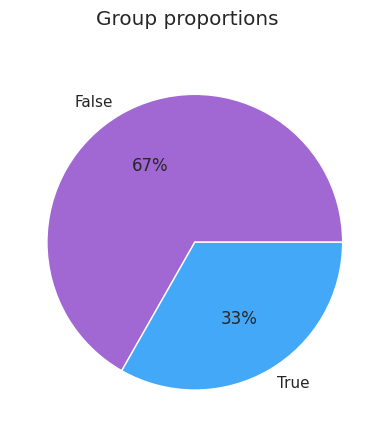

In [6]:
from holisticai.plots.bias import group_pie_plot

group_pie_plot(group_a)

The previous graphs show us that the proportion of male (labelled as *False*) is high compared to the female.

Let's plot the columns with the highest correlations with respect to the target variable. To do this, we will use the `correlation_matrix_plot` function. 

<Axes: >

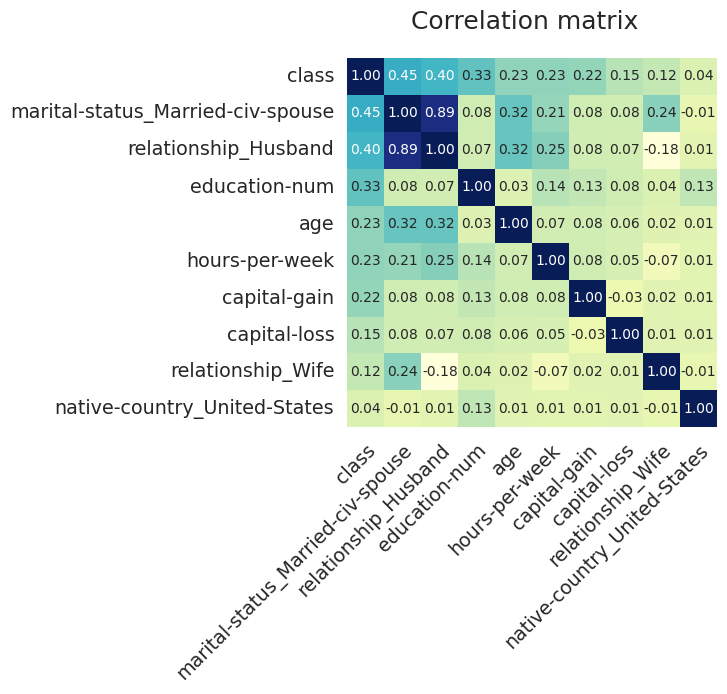

In [8]:
from holisticai.plots.bias import correlation_matrix_plot

correlation_matrix_plot(df, target_feature="class", n_features=10)

Now that we have our protected groups, we will define the input/output sets.

In [9]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X.shape, y.shape

((47985, 60), (47985,))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

## **4. Model training**

Once we have defined the training and testing sets, we can train a model as usual. Since the protected groups were separated from the dataset previously we do not need to take care of that in this opportunity, but do not forget to separate the protected attributes from the dataset, so that the model does not have any influence from these attributes in its training process. For the training process, we will use a traditional pipeline, we will fit and re-scale the training data, and then we will use the data to train a "Logistic regression" model and once the model has been trained, we can use its predictions to calculate the fairness metrics of the it.

In [12]:
# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from holisticai.pipeline import Pipeline

In [13]:
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [14]:
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train a simple linear classification model
LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data

X = scaler.transform(X)

# Predict values
y_pred = model.predict(X)

y_proba = model.predict_proba(X)
y_score = y_proba[:,1]
y_true = y

In [15]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.840471
Balanced accuracy,0.748136
Precision,0.696726
Recall,0.573322
F1-Score,0.629028


## **5. Bias measuring**

The fairness of the model can be calculated using the predictions of the model and the protected groups defined previously. The `holisticai` contains a module that calculates a set of metrics useful in evaluating the fairness of algorithmic decisions. For our case, we will use the `classification_bias_metrics6` function which allows us to select which metrics we want to calculate, if `equal_outcome`, `equal_opportunity` or `both`, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [16]:
from holisticai.bias.metrics import classification_bias_metrics

In [17]:
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Statistical Parity,-0.175836,0
Disparate Impact,0.304267,1
Four Fifths Rule,0.304267,1
Cohen D,-0.454655,0
2SD Rule,-20.530369,0
Equality of Opportunity Difference,-0.126491,0
False Positive Rate Difference,-0.082923,0
Average Odds Difference,-0.104707,0
Accuracy Difference,0.112691,0


For example:

*   **Statistical parity:** Computes the difference in success rates between the protected groups. Values below 0 are considered unfair towards `group_a` while values above 0 are considered unfair towards `group_b`, the range (-0.1, 0.1) is considered acceptable.
*   **Disparate Impact:** Shows the ratio of success rates between the protected groups for a certain quantile. Values below 1 are unfair towards `group_a`. Values above 1 are unfair towards `group_b`. The range (0.8, 1.2) is considered acceptable.
*   **Four Fifths:** Computes the ratio of success rates between the protected groups. Values below 1 are considered unfair while a range between (0.8, 1) is considered acceptable.
*   **Cohen D:** Computes the normalised statistical parity between the protected groups. Values below 0 are considered unfair towards `group_a` while values above 0 are considered unfair towards `group_b`.
*   **Equality of opportunity difference:** Computes the difference in true positive rates between the protected groups. Values below 0 are considered unfair towards `group_a` while values above 0 are considered unfair towards `group_b`.
*   **False positive rate difference:** Computes the difference in false positive rates between the protected groups, negative values indicating bias against `group_a` while positive values indicating bias against `group_b`.
*   **Average Odds Difference:** Computes the difference in average odds between the protected groups, negative values indicating bias against `group_a` while positive values indicating bias against `group_b`, a range between (-0.1, 0.1) is considered acceptable.
*   **Accuracy Difference:** Computes the difference in accuracy of predictions for the protected groups, positive values show bias against `group_b` while negative values show bias against `group_a`.


Source: [*HolisticAI docs*](https://holisticai.readthedocs.io/en/latest/metrics.html#binary-classification)

## **6. Bias mitigation**
### **Correlation remover: Preprocessing method**

Now that we could observe that the model metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present in the model.

Exists different kinds of strategies, and the literature has divided them into three categories: *Pre-processing*, *in-processing* and *post-processing* methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library. As you will see later, its implementation can be done following the traditional way, or by applying the pipeline. 

For this opportunity, we will implement the "Correlation remover" method which is a pre-processing technique that applies a linear transformation to the non-sensitive features of the dataset to remove the correlation with respect to the sensitive columns. This process is done aiming to maintain as much as possible to prevent lost information.


### **Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover

In [ ]:
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem = df.copy()
df_corr_rem

,Value,Reference
Metric,,
Statistical Parity,-0.113786,0
Disparate Impact,0.474747,1
Four Fifths Rule,0.474747,1
Cohen D,-0.299963,0
2SD Rule,-13.716201,0
Equality of Opportunity Difference,0.021647,0
False Positive Rate Difference,-0.039364,0
Average Odds Difference,-0.008859,0
Accuracy Difference,0.106908,0


### **Pipeline implementation**

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline! Notice that we shouldn't have variations in the metrics for the previous implementation.

In [ ]:
model = LogisticRegression()
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", model),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)
df = classification_bias_metrics(
    group_a,
    group_b,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p =df.copy()
df_corr_rem_w_p

,Value,Reference
Metric,,
Statistical Parity,-0.113786,0
Disparate Impact,0.474747,1
Four Fifths Rule,0.474747,1
Cohen D,-0.299963,0
2SD Rule,-13.716201,0
Equality of Opportunity Difference,0.021647,0
False Positive Rate Difference,-0.039364,0
Average Odds Difference,-0.008859,0
Accuracy Difference,0.106908,0


In [ ]:
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.838387
Balanced accuracy,0.733949
Precision,0.707872
Recall,0.536219
F1-Score,0.610204


## **7. Results comparison**

Now that we could observe how is the implementation of the mitigator in the model, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [ ]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Statistical Parity,-0.175836,-0.113786,-0.113786,0
Disparate Impact,0.304267,0.474747,0.474747,1
Four Fifths Rule,0.304267,0.474747,0.474747,1
Cohen D,-0.454655,-0.299963,-0.299963,0
2SD Rule,-20.530369,-13.716201,-13.716201,0
Equality of Opportunity Difference,-0.126491,0.021647,0.021647,0
False Positive Rate Difference,-0.082923,-0.039364,-0.039364,0
Average Odds Difference,-0.104707,-0.008859,-0.008859,0
Accuracy Difference,0.112691,0.106908,0.106908,0


From the previous chart, we can see that although the actual metrics are still far from the ideal values, an improvement is obtained by applying this method in the dataset, compared with our baseline. 

Notice that we can analyse how these values are affected by varying the hyperparameter of the method. For example, this method allows us to set an `alpha` parameter that controls how much information will be filtered, you will find more information in its documentation [here](https://holisticai.readthedocs.io/en/latest/.generated/holisticai.bias.mitigation.CorrelationRemover.html#holisticai.bias.mitigation.CorrelationRemover)

To observe the influence of this variation we will try with different values:

In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a, 
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  df = classification_bias_metrics(
      group_a,
      group_b,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha, 
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [ ]:
metrics_val = []
metrics_cols = ['Statistical Parity', 'Disparate Impact']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Statistical Parity,Disparate Impact
0,0.000000,0.840471,-0.175836,0.304267
1,0.136364,0.840263,-0.173804,0.311029
2,0.272727,0.840471,-0.171304,0.315855
3,0.409091,0.840679,-0.165052,0.332491
4,0.545455,0.839742,-0.157549,0.348837
5,0.681818,0.839429,-0.146921,0.375830
6,0.818182,0.840158,-0.136136,0.405461
7,0.954545,0.839533,-0.121444,0.449327
8,1.090909,0.836616,-0.097999,0.531040
9,1.227273,0.833906,-0.067990,0.651721


Text(0.5, 0, 'alpha')

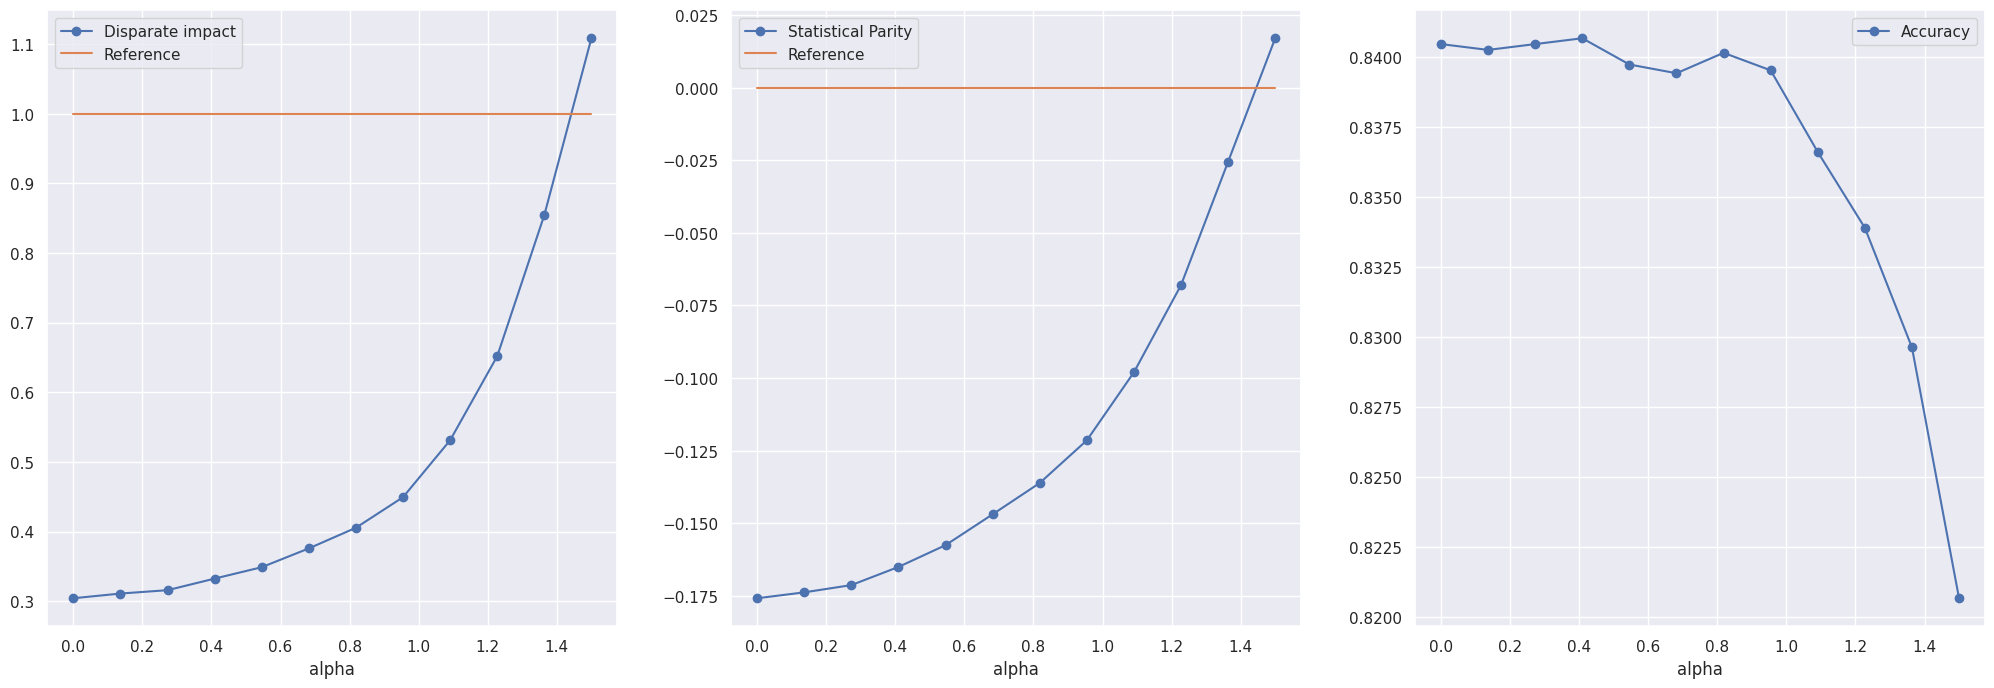

In [ ]:
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Disparate Impact'], 'o-', label='Disparate impact')
plt.plot(x_axis, np.ones_like(df_metrics['Disparate Impact']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Statistical Parity'], 'o-', label='Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

As we can see, the variation of this parameter shows that when we increase its value the results are closer to the reference, but we need into account that the higher the value of the parameter is, the more information will be filtered but the accuracy will be also affected. In general, the selection of the model parameters will depend on our main objective, whether we are looking for fairness or accuracy.

## **Summary**
Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in classification models by the application of the `classification_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the "Correlation remover" technique to train a fairness model by pre-processing the original dataset through the remotion of the correlation of the features with repect to the sensitive values. Consequently we could observe how the metrics are influenced by varing the `alpha` parameter, and showing how this method increases the fairness of the model.